In [1]:
# read conllu file and output a dataframe

import pandas as pd

def conllu_to_df(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines:
        if line.startswith('#'):
            continue
        if line == '\n':
            continue
        line = line.strip().split('\t')
        data.append(line)
    df = pd.DataFrame(data, columns=['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC'])
    return df

In [2]:
gsd = pd.concat([conllu_to_df('de_gsd-ud-train.conllu'), conllu_to_df('de_gsd-ud-dev.conllu'), conllu_to_df('de_gsd-ud-test.conllu')])
sequoia = pd.concat([conllu_to_df('fr_sequoia-ud-train.conllu'), conllu_to_df('fr_sequoia-ud-dev.conllu'), conllu_to_df('fr_sequoia-ud-test.conllu')])

In [3]:
# extract the nouns and its gender

def extract(df):
    nouns = df[df['UPOS'] == 'NOUN']    # extract the nouns
    nouns['FEATS'] = nouns['FEATS'].str.split('|')  # split the features
    nouns = nouns.explode('FEATS')  # explode the features
    nouns = nouns[nouns['FEATS'].str.contains('Gender')]
    nouns['FEATS'] = nouns['FEATS'].str.replace('Gender=', '')
    nouns = nouns.reset_index(drop=True) # remove index

    return nouns[['LEMMA', 'FEATS']]

In [4]:
gsd_extracted = extract(gsd)
sequoia_extracted = extract(sequoia)

/var/folders/fk/sn6tljf10t7141pzd63njhkw0000gn/T/ipykernel_11583/2984917641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nouns['FEATS'] = nouns['FEATS'].str.split('|')  # split the features
/var/folders/fk/sn6tljf10t7141pzd63njhkw0000gn/T/ipykernel_11583/2984917641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nouns['FEATS'] = nouns['FEATS'].str.split('|')  # split the features


In [5]:
# tokenize the nouns using BERT tokenizer

# BERT tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize(df):
    tokens = []
    for i in range(len(df)):
        token = tokenizer.tokenize(df['LEMMA'][i])
        tokens.append(token)
    df['TOKENS'] = tokens
    return df

In [6]:
# for each grammatical gender, 
# determine the distribution of the number of subtokens resulting from the tokenization of a noun

print(sequoia_extracted['FEATS'].unique())
print(gsd_extracted['FEATS'].unique())

['Fem' 'Masc']
['Fem' 'Neut' 'Masc']


In [7]:
# distribution of the number of subtokens

def subtokens(df):
    subtokens = []
    for i in range(len(df)):
        subtokens.append(len(df['TOKENS'][i]))
    df['SUBTOKENS'] = subtokens
    return df

In [8]:
gsd_extracted = tokenize(gsd_extracted)
sequoia_extracted = tokenize(sequoia_extracted)

gsd_extracted = subtokens(gsd_extracted)
sequoia_extracted = subtokens(sequoia_extracted)

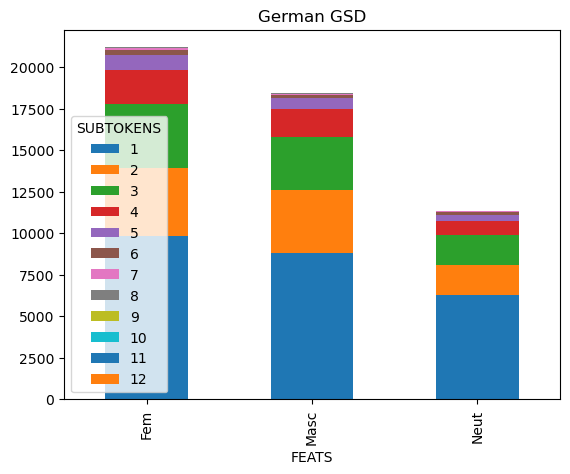

In [9]:
# distribution of the number of subtokens

import matplotlib.pyplot as plt

# GSD

gsd_extracted.groupby(['FEATS', 'SUBTOKENS']).size().unstack().plot(kind='bar', stacked=True)
plt.title('German GSD')
plt.show()

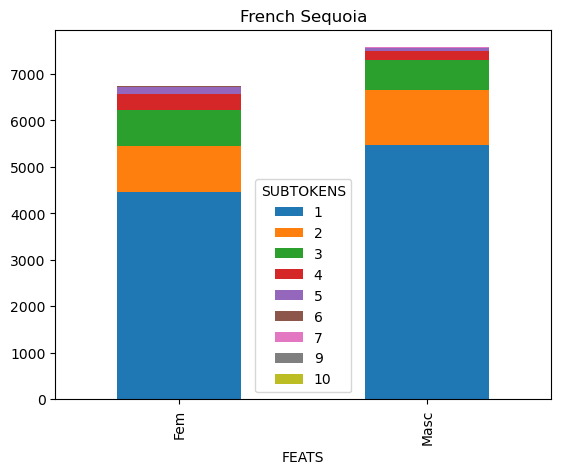

In [10]:
# Sequoia

sequoia_extracted.groupby(['FEATS', 'SUBTOKENS']).size().unstack().plot(kind='bar', stacked=True)
plt.title('French Sequoia')
plt.show()

In [11]:
# mean number of subtokens

print("Mean number of subtokens - GSD: \n", gsd_extracted.groupby('FEATS')['SUBTOKENS'].mean())
print("In general: \n", gsd_extracted['SUBTOKENS'].mean())
print("")
print("Mean number of subtokens - Sequoia: \n", sequoia_extracted.groupby('FEATS')['SUBTOKENS'].mean())
print("In general: \n", sequoia_extracted['SUBTOKENS'].mean())

Mean number of subtokens - GSD: 
 FEATS
Fem     2.137908
Masc    2.054168
Neut    1.942116
Name: SUBTOKENS, dtype: float64
In general: 
 2.064069094121111

Mean number of subtokens - Sequoia: 
 FEATS
Fem     1.629751
Masc    1.448567
Name: SUBTOKENS, dtype: float64
In general: 
 1.5338598085121253


In [12]:
# load the dataset

%pip install datasets
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import DistilBertModel,DistilBertTokenizer

dataset = load_dataset("amazon_polarity")

Note: you may need to restart the kernel to use updated packages.


/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Found cached dataset parquet (/Users/hwanghaeeul/.cache/huggingface/datasets/parquet/amazon_polarity-d710a5a73b03c7f7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# convert the dataset to pandas dataframe

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

In [14]:
# load the model and tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # use gpu if available
model = DistilBertModel.from_pretrained('distilbert-base-uncased')      # load the model    
model.to(device)                                                        # move the model to the device
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # load the tokenizer

In [15]:
# sample the dataset to get a smaller dataset

df_train_sample = df_train.sample(frac = 0.001, random_state = 42)
df_test_sample = df_test.sample(frac = 0.001, random_state = 42)

In [16]:
# tokenize the dataset

def tokenize_data(data):
    tokenized_data = tokenizer(data['title'].tolist(), padding = True, truncation = True, return_tensors = 'pt')
    return tokenized_data

train_data = tokenize_data(df_train_sample)
test_data = tokenize_data(df_test_sample)

In [17]:
# get the embeddings of the dataset using [CLS] token with batch size 32

def get_embeddings(data, batch_size = 32):
    dataset = TensorDataset(data['input_ids'], data['attention_mask'])
    dataloader = DataLoader(dataset, batch_size = batch_size)
    embeddings = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids, attention_mask)
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu())
    return torch.cat(embeddings)

In [18]:
train_data_embeddings = get_embeddings(train_data)
test_data_embeddings = get_embeddings(test_data)

In [19]:
print(train_data_embeddings)

tensor([[-0.0577,  0.0581, -0.0677,  ..., -0.1035,  0.2031,  0.1593],
        [-0.1691,  0.0046,  0.1411,  ..., -0.0461,  0.2772,  0.2308],
        [ 0.0060, -0.1137, -0.0463,  ..., -0.0836,  0.3741,  0.1967],
        ...,
        [-0.2401, -0.1052, -0.0397,  ..., -0.1129,  0.1271,  0.2477],
        [-0.3180, -0.1362,  0.0377,  ...,  0.0066,  0.3107,  0.3087],
        [-0.0817, -0.0481,  0.1074,  ..., -0.0175,  0.2291,  0.1326]])


In [20]:
# train a logistic regression model

clf = LogisticRegression(random_state = 42)
clf.fit(train_data_embeddings.cpu().numpy(), df_train_sample['label'])

# predict the test data

y_pred = clf.predict(test_data_embeddings.cpu().numpy())
accuracy = accuracy_score(df_test_sample['label'], y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.795


/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# test for different training sizes

train_sizes = [0.002, 0.003]
accuracies = []

for train_size in train_sizes:
    df_train_sample = df_train.sample(frac = train_size, random_state = 42)
    train_data = tokenize_data(df_train_sample)
    train_data_embeddings = get_embeddings(train_data)
    clf = LogisticRegression(random_state = 42)
    clf.fit(train_data_embeddings.cpu().numpy(), df_train_sample['label'])
    y_pred = clf.predict(test_data_embeddings.cpu().numpy())
    accuracy = accuracy_score(df_test_sample['label'], y_pred)
    accuracies.append(accuracy)
    print(f'Training size: {train_size}, Accuracy: {accuracy}')

/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training size: 0.002, Accuracy: 0.8125
Training size: 0.003, Accuracy: 0.8325


/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# get the embeddings of the dataset using mean pooling with batch size 32

def get_embeddings_mean_pooling(data, batch_size = 32):
    dataset = TensorDataset(data['input_ids'], data['attention_mask'])
    dataloader = DataLoader(dataset, batch_size = batch_size)
    embeddings = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids, attention_mask)
            mask = attention_mask.unsqueeze(2).expand(outputs.last_hidden_state.size())
            sum_embeddings = torch.sum(outputs.last_hidden_state * mask, 1)
            mask = mask.sum(1)
            embeddings.append(sum_embeddings / mask)
    return torch.cat(embeddings)

train_data_mean_embeddings = get_embeddings_mean_pooling(train_data)
test_data_mean_embeddings = get_embeddings_mean_pooling(test_data)

In [23]:
print(train_data_mean_embeddings)

tensor([[ 0.6212,  0.0946, -0.1234,  ...,  0.0698,  0.0281, -0.2947],
        [ 0.2166,  0.1787,  0.1601,  ...,  0.0316,  0.0041,  0.0161],
        [ 0.2459, -0.2916,  0.1652,  ...,  0.0113,  0.3953, -0.3773],
        ...,
        [ 0.2698,  0.0485,  0.1040,  ...,  0.1547,  0.1225, -0.0175],
        [ 0.4098, -0.1291, -0.0192,  ..., -0.0507, -0.1176, -0.2380],
        [-0.0694, -0.2053,  0.0203,  ..., -0.1904, -0.1495, -0.0272]])


In [24]:
# train a logistic regression model

clf = LogisticRegression(random_state = 42)
clf.fit(train_data_mean_embeddings.cpu().numpy(), df_train_sample['label'])

# predict the test data

y_pred = clf.predict(test_data_mean_embeddings.cpu().numpy())
accuracy = accuracy_score(df_test_sample['label'], y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.83


/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# test for different training sizes

train_sizes = [0.002, 0.003]
accuracies = []

for train_size in train_sizes:
    df_train_sample = df_train.sample(frac = train_size, random_state = 42)
    train_data = tokenize_data(df_train_sample)
    train_data_mean_embeddings = get_embeddings_mean_pooling(train_data)
    clf = LogisticRegression(random_state = 42)
    clf.fit(train_data_mean_embeddings.cpu().numpy(), df_train_sample['label'])
    y_pred = clf.predict(test_data_mean_embeddings.cpu().numpy())
    accuracy = accuracy_score(df_test_sample['label'], y_pred)
    accuracies.append(accuracy)
    print(f'Training size: {train_size}, Accuracy: {accuracy}')

/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training size: 0.002, Accuracy: 0.82
Training size: 0.003, Accuracy: 0.83


/Users/hwanghaeeul/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
